## Understanding missingness and basic data exploration

In [ ]:
# Import libraries
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import yaml
import seaborn as sns

# Connect to database
with open('../database.yaml', 'r') as f:
    db_params = yaml.safe_load(f)

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['db'],
  user=db_params['user'],
  password=db_params['pass']    
))

### Merge gaps between tables

In [10]:
### Using monthly tax as the base, checking what we don't have building info / historical sales data for

### Between monthly tax, building info, historical sales

## Selecting those that are in Monthly Tax that are missing in either HS or BI
sql = '''
select mt.*, hs.*, bi.*, 
       (case when hs.parcelid is null then 0 else 1 end) "hs_match", 
       (case when bi.parcelid is null then 0 else 1 end) "bi_match"
from cleaned.monthly_tax mt left join cleaned.building_info bi on mt.parcelid = bi.parcelid
	  left join cleaned.historic_sales hs on mt.parcelid = hs.parcelid
'''

df = pd.read_sql(sql, engine)

print(f'{len(df)} observations exist in Monthly Tax that do not match to either historic sales or building info')

hs_mismatches = int(df['hs_match'].isna().sum())
bi_mismatches = int(df['bi_match'].isna().sum())

print(f'{hs_mismatches} observations exist in Monthly Tax that do not match to historic sales')
print(f'{bi_mismatches} observations exist in Monthly Tax that do not match to building info')

255865 observations exist in Monthly Tax that do not match to either historic sales or building info
0 observations exist in Monthly Tax that do not match to historic sales
0 observations exist in Monthly Tax that do not match to building info


### Building Info

In [11]:
# Selecting only buildings with property class info

## Note: there are 339 buildings in building info that don't merge with monthly tax (where we get property codes from)
## Property class codes are nonmissing for all other observations

query = '''select bi.*, mt.prop_class_code, mt.class_description
from cleaned.building_info bi join cleaned.monthly_tax mt using(parcelid)
where prop_class_code in (510, 550, 520, 401, 530, 625, 404, 470)'''

bi = pd.read_sql(query, engine)

# Null % for each variable
print('Percentage of nulls:')
print(bi.isnull().mean())

# Description of data
print('\n Descriptive stats for data')
bi.describe()


Percentage of nulls:
parcelid             0.0
ATTIC_SQFT           0.0
BSMT_SQFT            0.0
LIVE_FSQFT           0.0
SQFT                 1.0
SQFT_FLR1            0.0
SQFT_FLR2            0.0
SQFT_FLRH            0.0
STORYHT              0.0
YEARBUILT            0.0
prop_class_code      0.0
class_description    0.0
dtype: float64

 Descriptive stats for data


,ATTIC_SQFT,BSMT_SQFT,LIVE_FSQFT,SQFT_FLR1,SQFT_FLR2,SQFT_FLRH,STORYHT,YEARBUILT,prop_class_code
count,247481.000000,247481.000000,247481.000000,247481.000000,247481.000000,247481.000000,247481.000000,247481.000000,247481.000000
mean,90.352144,946.334381,1777.079582,1184.614092,500.884589,45.300661,1.507560,1953.663930,513.743952
std,214.103700,634.598265,850.057646,531.192581,581.851919,186.843445,0.512318,38.570605,12.330594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.000000
25%,0.000000,676.000000,1208.000000,864.000000,0.000000,0.000000,1.000000,1930.000000,510.000000
50%,0.000000,932.000000,1575.000000,1053.000000,370.000000,0.000000,1.500000,1957.000000,510.000000
75%,0.000000,1216.000000,2120.000000,1356.000000,936.000000,0.000000,2.000000,1976.000000,510.000000
max,6679.000000,14898.000000,21136.000000,11697.000000,15750.000000,6034.000000,41.750000,2020.000000,625.000000


In [14]:
# Digging into cases where year built = 0
bi[bi['YEARBUILT'] == 0]
# 2440 rows where yearbuilt = 0

# Almost all of these have 0 for all values (strong correlation of missingness)

# For these cases, do they merge onto year_built in historic_sales?
sql = '''
SELECT b.parcelid, b."YEARBUILT", h.year_built
FROM cleaned.building_info b left join cleaned.historic_sales h on b.parcelid = h.parcelid
WHERE b."YEARBUILT" = 0
'''

df = pd.read_sql(sql, engine)

# are there any with nonzero values in other imp variables?
bi[(bi['YEARBUILT'] == 0)&(bi['LIVE_FSQFT'] > 0)]

bi[(bi['YEARBUILT'] == 0)&(bi['BSMT_SQFT'] > 0)]
# There are 17 rows that have nonmissing bsmt sqft (these have)

bi[(bi['YEARBUILT'] != 0)&(bi['LIVE_FSQFT'] == 0)]
# There are an additional 646 rows where year built is not 0, butl live fsqft is zero

,parcelid,ATTIC_SQFT,BSMT_SQFT,LIVE_FSQFT,SQFT,SQFT_FLR1,SQFT_FLR2,SQFT_FLRH,STORYHT,YEARBUILT,prop_class_code,class_description
1546,5100380013200,0,0,0,None,0,0,0,0.0,2020,510,SINGLE FAMILY DWLG
19789,0400006011100,0,0,0,None,0,0,0,0.0,2020,510,SINGLE FAMILY DWLG
24952,5100251005000,0,945,0,None,0,0,0,0.0,2015,510,SINGLE FAMILY DWLG
35994,5000410013700,0,981,0,None,0,0,0,0.0,2015,510,SINGLE FAMILY DWLG
36303,5100130013000,0,0,0,None,0,0,0,0.0,2020,510,SINGLE FAMILY DWLG
...,...,...,...,...,...,...,...,...,...,...,...,...
234129,5290152004500,0,0,0,None,0,0,0,0.0,2020,510,SINGLE FAMILY DWLG
236095,0200001001300,0,0,0,None,0,0,0,0.0,2020,510,SINGLE FAMILY DWLG
236431,0970002016700,0,660,0,None,0,0,0,0.0,2015,510,SINGLE FAMILY DWLG
242496,5610028001500,0,0,0,None,0,0,0,0.0,2018,510,SINGLE FAMILY DWLG


Takeaways and to-dos:
- On what basis to convert to nulls?

### Property Transfers

In [ ]:
pt = pd.read_sql('select * from cleaned.property_transfer', engine)

In [36]:
# Null % for each variable
print('Percentage of nulls:')
print(pt.drop(['book', 'plat', 'parcel', 'multi_owner', 'property_no'], axis=1).isnull().mean())

# Description of data
print('\n Descriptive stats for numeric data')

pd.set_option('display.float_format', lambda x: '%.5f' % x)

pt.describe()

Percentage of nulls:
tax_district        0.000000
owner_name_1        0.000015
owner_name_2        0.513467
land_value          0.028928
building_value      0.028928
property_class      0.000000
house_no            0.025737
street_name         0.002332
street_suffix       0.009853
zip_code            0.370335
month_of_sale       0.000000
day_of_sale         0.000000
year_of_sale        0.000000
num_parcels_sold    0.000002
sale_price          0.000000
valid_sale          0.000000
conveyance_no       0.002829
deed_type           0.000110
appraisal_area      0.370378
prior_owner         0.370335
property_no         0.370337
parcelid            0.000000
is_new              0.000000
date_of_sale        0.000000
dtype: float64

 Descriptive stats for data


,land_value,building_value,sale_price,is_new
count,504309.00000,504309.00000,519332.00000,519332.00000
mean,46667.91428,121029.30656,260083.88887,0.02893
std,219553.83511,655001.61581,1723998.86083,0.16760
min,0.00000,0.00000,1.00000,0.00000
25%,13800.00000,39200.00000,66600.00000,0.00000
50%,21800.00000,73000.00000,120000.00000,0.00000
75%,36400.00000,116300.00000,210000.00000,0.00000
max,48430540.00000,165218900.00000,218201000.00000,1.00000


<AxesSubplot:xlabel='date_of_sale', ylabel='Count'>

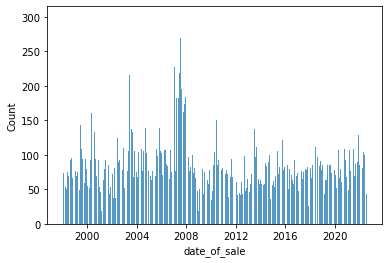

In [39]:
sns.histplot(pt['date_of_sale'])

In [53]:
# Distribution of number of sales by parcelid 
sale_counts = pt.groupby('parcelid')['date_of_sale'].count()

sale_counts.describe()

count   236429.00000
mean         2.19657
std          2.06120
min          1.00000
25%          1.00000
50%          2.00000
75%          3.00000
max        699.00000
Name: date_of_sale, dtype: float64

In [55]:
print('\n Top 5 zip codes for sales')

print(pt['zip_code'].value_counts()[0:6,])

print('\n Bottom 5 zip codes for sales')
print(pt['zip_code'].value_counts()[-5:,])



 Top 5 zip codes for sales
00000-0000    53514
45205-0000     5579
45211-0000     5386
45231-0000     5044
45238-0000     4433
45215-0000     4408
Name: zip_code, dtype: int64

 Bottom 5 zip codes for sales
45243-2306    1
45225-2023    1
45230-4122    1
45243-3014    1
45224-2908    1
Name: zip_code, dtype: int64


In [56]:
pt['property_class'].value_counts()
# 510 is single family dwelling

510    328638
500     55901
550     37854
520     26966
401     13397
        ...  
407         1
428         1
467         1
451         1
660         1
Name: property_class, Length: 143, dtype: int64

### Monthly Tax

In [57]:
mt = pd.read_sql('select * from cleaned.monthly_tax', engine)

In [58]:
# Null % for each variable
print('Percentage of nulls:')
print(mt.isnull().mean())

# Description of data
print('\n Descriptive stats for numeric data')

pd.set_option('display.float_format', lambda x: '%.5f' % x)

mt.describe()

Percentage of nulls:
parcelid                0.00000
2_5_flag                0.00000
homestead_flag          0.00000
book                    0.00000
page                    0.00000
                          ...  
annual_taxes            0.08237
annual_taxes_paid       0.08237
delinquent_taxes        0.01352
delinquent_taxes_paid   0.01352
active_flag             0.00000
Length: 62, dtype: float64

 Descriptive stats for numeric data


,book,mltown,prop_class_code,appraisal_area,tax_district,deeded_acreage,sale_amount,num_parcels,sale_source,ag_use,market_land_value,market_impr_value,total_market_value,annual_taxes,annual_taxes_paid,delinquent_taxes,delinquent_taxes_paid
count,353973.00000,353973.00000,353973.00000,353711.00000,353973.00000,353973.00000,302538.00000,350659.00000,101815.00000,353973.00000,351339.00000,351339.00000,351339.00000,324815.00000,324815.00000,349186.00000,349186.00000
mean,414.29742,3.99893,513.28860,49041.24421,87.95686,0.70638,167687.79765,3.58672,209725.28227,173.36031,57445.21389,186902.36793,244347.58182,5507.90332,5341.34554,211.88313,106.52509
std,215.53976,18.54434,58.96647,79799.36705,83.46557,5.48821,1025587.58898,24.18731,104144.48974,7365.46212,280713.78682,3099339.64346,3184371.26928,103010.59441,102076.21635,10298.68413,9593.33292
min,1.00000,0.00000,100.00000,100.00000,1.00000,0.00000,0.00000,1.00000,1997.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-4317657.70000,-4317657.70000
25%,194.00000,0.00000,510.00000,3700.00000,1.00000,0.10400,0.00000,1.00000,124288.00000,0.00000,14100.00000,24170.00000,47750.00000,1358.92500,1233.10500,0.00000,0.00000
50%,525.00000,0.00000,510.00000,52506.00000,68.00000,0.18130,79100.00000,1.00000,223962.00000,0.00000,26330.00000,83640.00000,114000.00000,2667.76000,2601.65000,0.00000,0.00000
75%,590.00000,0.00000,510.00000,59201.00000,163.00000,0.38100,176000.00000,1.00000,301349.50000,0.00000,48990.00000,157500.00000,210795.00000,4804.85500,4728.92500,0.00000,0.00000
max,671.00000,90.00000,881.00000,550186.00000,241.00000,1059.01000,134000000.00000,466.00000,363807.00000,1865000.00000,53979960.00000,1388727510.00000,1388727510.00000,53077165.60000,53077165.60000,1069602.42000,884991.85000


### Historic Sales

In [16]:
hs = pd.read_sql('''select * from cleaned.historic_sales
                  where use_code in (510, 550, 520, 401, 530, 625, 404, 470)''', engine)

In [17]:
# Null % for each variable
print('Percentage of nulls:')
print(hs[['sale_price', 'transfer_type', 'style', 'grade', 'exterior_wall_type', 'basement', 'heating', 'air_conditioning',
       'total_rooms', 'full_bath', 'half_bath', 'fireplaces', 'garage_type',
       'garage_capacity', 'num_stories', 'year_built', 'finished_sq_ft',
       'total_finish_area', 'first_floor_area', 'half_floor_area',
       'finished_basement']].isnull().mean())

# Description of data
print('\n Descriptive stats for numeric data')

pd.set_option('display.float_format', lambda x: '%.5f' % x)

hs.describe()

Percentage of nulls:
sale_price            0.133935
transfer_type         0.005348
style                 0.002493
grade                 0.002027
exterior_wall_type    0.002408
basement              0.147927
heating               0.002027
air_conditioning      0.002027
total_rooms           0.002027
full_bath             0.002027
half_bath             0.002027
fireplaces            0.002027
garage_type           0.221872
garage_capacity       0.000000
num_stories           0.002027
year_built            0.002060
finished_sq_ft        0.002027
total_finish_area     0.002027
first_floor_area      0.002027
half_floor_area       0.002027
finished_basement     0.002027
dtype: float64

 Descriptive stats for numeric data


,use_code,number_of_parcels,conveyance_number,appraisal_area,total_sales_records,sale_price,subdivision,tax_year,total_rooms,full_bath,half_bath,fireplaces,garage_capacity,num_stories,year_built,finished_sq_ft,total_finish_area,first_floor_area,half_floor_area,finished_basement
count,246642.00000,245341.00000,220015.00000,246594.00000,245341.00000,213608.00000,246642.00000,246642.00000,246142.00000,246142.00000,246142.00000,246142.00000,246642.00000,246142.00000,246134.00000,246142.00000,246142.00000,246142.00000,246142.00000,246142.00000
mean,513.91040,3.63417,114692.99566,53974.18893,1.05377,142932.35006,2.27642,2021.00000,6.67299,1.69394,0.48459,0.52877,272.67834,1.46387,1953.94627,1335.53832,1776.05518,1185.13135,499.55248,155.14422
std,11.14182,28.01990,104238.34537,85859.76562,0.26983,206116.67253,196.78940,0.00000,1.91254,0.76913,0.58942,0.67659,291.07894,0.51751,35.36618,822.31436,846.03797,530.65384,580.14993,359.77094
min,510.00000,1.00000,0.00000,100.00000,1.00000,0.00000,0.00000,2021.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,510.00000,1.00000,10853.50000,4400.00000,1.00000,0.00000,0.00000,2021.00000,5.00000,1.00000,0.00000,0.00000,1.00000,1.00000,1930.00000,893.00000,1209.00000,866.00000,0.00000,0.00000
50%,510.00000,1.00000,89142.00000,54002.00000,1.00000,102500.00000,0.00000,2021.00000,6.00000,2.00000,0.00000,0.00000,252.00000,1.00000,1957.00000,1107.00000,1575.00000,1053.00000,358.00000,0.00000
75%,510.00000,1.00000,213452.00000,59209.00000,1.00000,187500.00000,0.00000,2021.00000,8.00000,2.00000,1.00000,1.00000,462.00000,2.00000,1976.00000,1503.00000,2118.00000,1356.00000,936.00000,0.00000
max,550.00000,466.00000,680684.00000,550186.00000,29.00000,5700000.00000,17014.00000,2021.00000,96.00000,12.00000,20.00000,10.00000,8521.00000,11.00000,2020.00000,27072.00000,21136.00000,11697.00000,15750.00000,9548.00000


In [20]:
hs_zero_sale_price = hs[hs['sale_price'] == 0]

hs_zero_sale_price


,parcelid,use_code,number_of_parcels,conveyance_number,owner_name_1,owner_name_2,owner_address_1,owner_address_2,date_of_sale,instrument_type,...,fireplaces,garage_type,garage_capacity,num_stories,year_built,finished_sq_ft,total_finish_area,first_floor_area,half_floor_area,finished_basement
5,5500242001200,510,1.00000,NaN,HACKER RAYMOND M,None,3567 EBENEZER RD,"CINCINNATI, OH, 452483007",2013-05-09,AF - Affidavit (EX),...,1.00000,Attached-Brick Construction,504,1.00000,1952.00000,1410.00000,1410.00000,1410.00000,0.00000,0.00000
9,5500242001600,510,1.00000,NaN,SCHOLZ GREGORY,& JENNIFER,3521 EBENEZER RD,"CINCINNATI, OH, 45248",2011-07-26,QE - Quit Claim Deed (EX),...,1.00000,Attached-Brick Construction,644,1.00000,1960.00000,1664.00000,1664.00000,1664.00000,0.00000,0.00000
14,5500242002300,510,1.00000,0.00000,SAULSBURY EMALIE C,None,3469 EBENEZER RD,"CINCINNATI, OH, 452483018",1990-02-01,WE - Warranty Deed (EX),...,1.00000,Detached-001-Frame Construction,342,1.00000,1935.00000,1254.00000,1848.00000,1254.00000,594.00000,400.00000
15,5500242002400,510,1.00000,0.00000,DIERSING JAMES J,& SUSAN P,3465 EBENEZER RD,"CINCINNATI, OH, 452483018",1978-08-01,WE - Warranty Deed (EX),...,1.00000,Attached-Integral Garage,572,2.00000,1955.00000,838.00000,2008.00000,838.00000,1170.00000,0.00000
16,5500242002500,510,1.00000,0.00000,HARRIS RICHARD W,None,3459 EBENEZER RD,"CINCINNATI, OH, 452483018",2003-07-30,WE - Warranty Deed (EX),...,1.00000,Basement Garage,1,1.00000,1937.00000,816.00000,1208.00000,816.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246615,5500241025000,510,1.00000,0.00000,MADIX WILLIAM P & ANNE M,None,6289 BERAUER RD,"CINCINNATI, OH, 45248",1993-01-14,WE - Warranty Deed (EX),...,1.00000,Attached-Brick Construction,484,2.00000,1992.00000,932.00000,1952.00000,932.00000,1020.00000,0.00000
246617,5500241025200,510,1.00000,0.00000,ROBISON THOMAS W &,CONSTANCE A,6265 BERAUER RD,"CINCINNATI, OH, 45248",1993-01-14,WE - Warranty Deed (EX),...,1.00000,Attached-Brick Construction,400,2.00000,1992.00000,1362.00000,2502.00000,1362.00000,1140.00000,0.00000
246618,5500241025300,510,1.00000,0.00000,STEWART THERESE M,None,6249 BERAUER RD,"CINCINNATI, OH, 45248",1997-07-18,WE - Warranty Deed (EX),...,1.00000,Attached-Brick Construction,550,1.00000,1992.00000,2190.00000,2190.00000,2190.00000,0.00000,0.00000
246619,5500241025400,510,1.00000,0.00000,MEYER MARK A & DEBRA K,None,6247 BERAUER RD,"CINCINNATI, OH, 45248",1993-01-14,WE - Warranty Deed (EX),...,1.00000,Attached-Brick Construction,440,2.00000,1992.00000,1340.00000,2228.00000,1340.00000,888.00000,0.00000


In [21]:
hs_zero_sale_price['instrument_type'].value_counts()

WE - Warranty Deed (EX)             38409
QE - Quit Claim Deed (EX)            8021
AF - Affidavit (EX)                  4335
PC - Probate Court (EX)              1769
SE - Survivorship Deed (EX)          1310
FE - Fiduciary Deed (EX)              358
BS - Boundary Survey (EX)             244
SF - Sheriff Deed (EX)                134
AD - Auditors Deed (EX)                87
NC - New Condominium (EX)              72
WD - Warranty Deed (Conv)              57
TR - Trustees Deed (Conv)              54
NS - New Subdivision (EX)              43
SV - Survivorship Deed (Conv)          36
QU - Quit Claim Deed (Conv)            33
LE - Limited Warranty Deed (EX)        19
LW - Limited Warrant Deed (Conv)       14
EXD - Executors Deed (Conv)            10
AC - Acceptance (EX)                    5
TE - Trustees Deed (EX)                 4
GE - Governors Deed (EX)                4
CE - Corporation Deed (EX)              4
DO - Deed of Ordinance (EX)             3
FD - Fiduciary Deed (Conv)        

In [22]:
hs['instrument_type'].value_counts()

WD - Warranty Deed (Conv)             100727
WE - Warranty Deed (EX)                73024
QE - Quit Claim Deed (EX)              18583
SV - Survivorship Deed (Conv)          13691
AF - Affidavit (EX)                     8777
FD - Fiduciary Deed (Conv)              5141
LW - Limited Warrant Deed (Conv)        5102
PC - Probate Court (EX)                 3389
LE - Limited Warranty Deed (EX)         3099
QU - Quit Claim Deed (Conv)             2540
TR - Trustees Deed (Conv)               2489
SE - Survivorship Deed (EX)             2474
EXD - Executors Deed (Conv)             2379
SH - Sheriff Deed (Conv)                 953
FE - Fiduciary Deed (EX)                 888
BS - Boundary Survey (EX)                482
SF - Sheriff Deed (EX)                   446
TE - Trustees Deed (EX)                  358
AD - Auditors Deed (EX)                  115
ADC - Administrators (Conv)              100
NC - New Condominium (EX)                 99
VS - Vacation of Street (EX)              78
EE - Execu

In [25]:
hs[hs['year_built'] == 0]

,parcelid,use_code,number_of_parcels,conveyance_number,owner_name_1,owner_name_2,owner_address_1,owner_address_2,date_of_sale,instrument_type,...,fireplaces,garage_type,garage_capacity,num_stories,year_built,finished_sq_ft,total_finish_area,first_floor_area,half_floor_area,finished_basement
4766,5500323043700,550,2.00000,237140.00000,GIGGLES AND O LLC,None,7621 SKYVIEW CIR,"CINCINNATI, OH, 45248",2020-06-26,WE - Warranty Deed (EX),...,0.00000,Detached-001-Frame Construction,253,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
23384,5900203011900,510,3.00000,160187.00000,SEYMOUR EMPIRE LLC,None,3958 SCHROEDER DR,"HAMILTON, OH, 45011",2017-12-22,FE - Fiduciary Deed (EX),...,0.00000,Detached-001-Frame Construction,1152,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
31094,5900382000400,510,1.00000,17981.00000,WOELLERT JEFF,None,10130 HAMILTON AVE,"CINCINNATI, OH, 452312102",2003-10-27,WE - Warranty Deed (EX),...,0.00000,"Detached-003-Frame, w/Loft",736,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
71669,6120010006600,510,4.00000,102319.00000,DENNY MAC LAND LLC,None,8793 KENWOOD ROAD,"CINCINNATI, OH, 45242",2016-02-19,QE - Quit Claim Deed (EX),...,0.00000,Detached-001-Frame Construction,660,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
76978,6200092001100,510,3.00000,8156.00000,HUEBER RICHARD,None,PO BOX 30309,"CINCINNATI, OH, 45244",2001-06-14,WE - Warranty Deed (EX),...,0.00000,None,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
84423,6300140011900,510,4.00000,287637.00000,GRAVEL FARM LLC,None,6111 MORGAN RD,"CLEVES, OH, 45002",2021-12-01,WE - Warranty Deed (EX),...,0.00000,None,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
84560,6300160001900,510,1.00000,276896.00000,SOWDERS SHAWN G,None,9150 KOPP LN,"CLEVES, OH, 45002",2021-08-20,QE - Quit Claim Deed (EX),...,0.00000,None,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
119525,0790006035400,550,4.00000,60723.00000,HURWITZ JENNIFER C,None,309 OREGON ST,"CINCINNATI, OH, 45202",2013-11-13,WD - Warranty Deed (Conv),...,0.00000,Detached-010-Masonry,162,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
184797,5010009052500,550,2.00000,NaN,BUSCH SUSAN E,None,7285 THOMAS DR,"CINCINNATI, OH, 45243",2009-10-26,SE - Survivorship Deed (EX),...,0.00000,Detached-001-Frame Construction,253,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
212582,5270040048800,510,10.00000,NaN,BOWERS BRADLEY J,None,PO BOX 9578,"CINCINNATI, OH, 45209",2007-12-21,WE - Warranty Deed (EX),...,0.00000,Detached-001-Frame Construction,380,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
